In [1]:
import avstack
import avapi

data_dir = '/data/spencer/CARLA/object-v1/'
CSM = avapi.carla.CarlaScenesManager(data_dir=data_dir)

Cannot import rss library -- don't worry about this unless you need 'safety' evals
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
CSM.scenes

['run_2023_09_06_09:43:29',
 'run_2023_09_06_09:43:48',
 'run_2023_09_06_09:44:08']

In [3]:
CDM = CSM.get_scene_dataset_by_index(0)

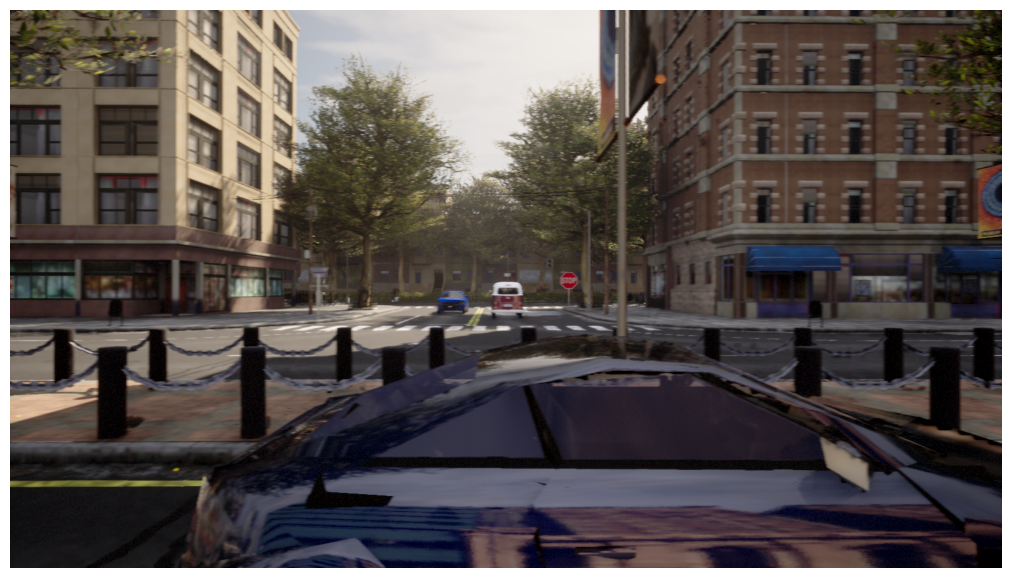

In [21]:
frame = CDM.frames[-3]
img = CDM.get_image(frame=frame, sensor="CAM_FRONT_LEFT")
objs = CDM.get_objects(frame=frame, sensor="CAM_FRONT_RIGHT", max_occ=avstack.environment.objects.Occlusion.PARTIAL)
avapi.visualize.snapshot.show_image_with_boxes(img, boxes=objs, inline=True)